Simple recurrent neural network (RNN) implementation in Keras using LSTM (long short-term memory) units to identify time of occurence of some events in temporal data based on the wavelet spectrogram of the data

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow
from tensorflow import keras
import h5py # TODO: use tensorflow.keras.utils.HDF5Matrix

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11990980496011193079
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4108793909956442515
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12288129830315641291
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11269973607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11307047175062475548
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
np.random.seed(1234)

# Load training/validation data

In [5]:
# load training/validation datas with labels
f = h5py.File(os.path.join('data', 'processed', 'data.h5'), 'r')
X0 = f['X0'][:]
X = f['X'][:]
Y = f['Y'][:]
labels = f['labels'][:]
waveletfreqs = f['waveletfreqs'][:]
f.close()

# center raw data
X0 = (X0.T - X0.mean(axis=-1)).T

# randomly permute order of datasets
permutation = np.random.permutation(np.arange(X0.shape[0]))
X0 = X0[permutation]
X = X[permutation]
Y = Y[permutation]
labels = labels[permutation]

In [6]:
# some needed parameters
n_samples = X0.shape[0]
Fs = 2500 # Hz, sampling freq
time = np.arange(X0.shape[1]) / Fs
n_val_samples = 50 # number of validation samples

Text(0.5, 0, 't (s)')

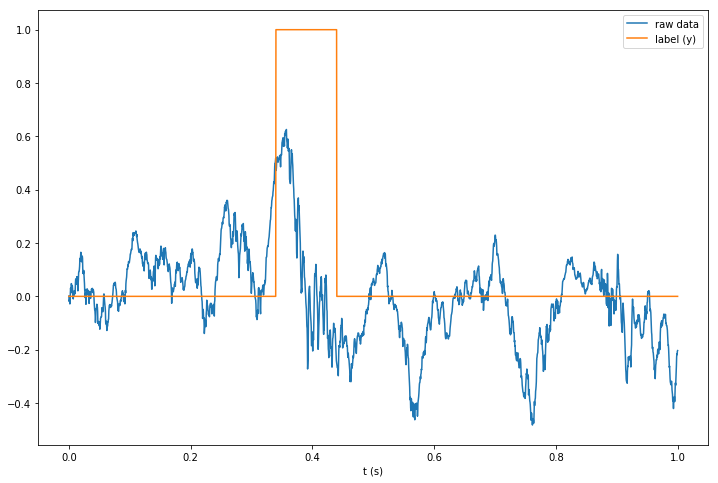

In [19]:
# test plot
plt.figure(figsize=(12, 8))
plt.plot(time, X0[0, :], label='raw data')
plt.plot(time, Y[0, :, 0], label='label (y)')
plt.legend()
plt.xlabel('t (s)')

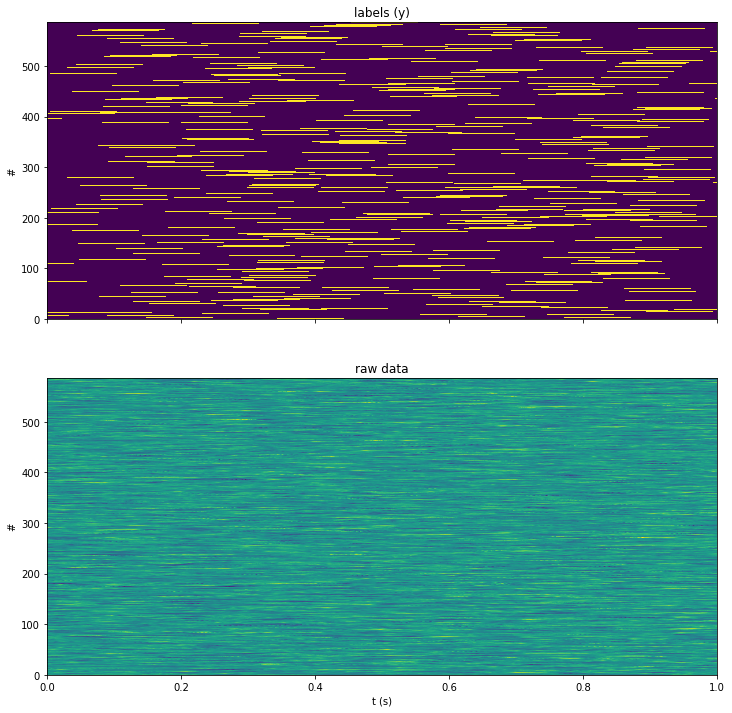

In [8]:
# plot all labels and raw data matrices
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 12))
axes[0].pcolormesh(time, np.arange(n_samples), Y[:, :, 0])
axes[0].set_ylabel('#')
axes[0].set_title('labels (y)')
axes[1].pcolormesh(time, np.arange(n_samples), X0)
axes[1].set_ylabel('#')
axes[1].set_xlabel('t (s)')
axes[1].set_title('raw data')
for ax in axes:
    ax.axis(ax.axis('tight'))

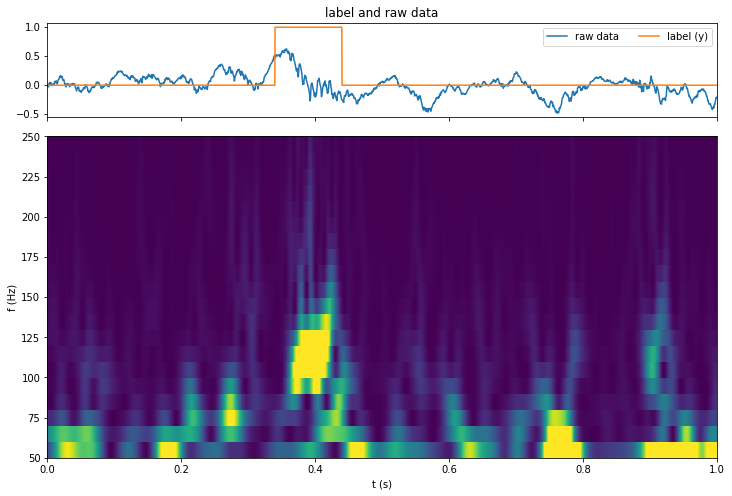

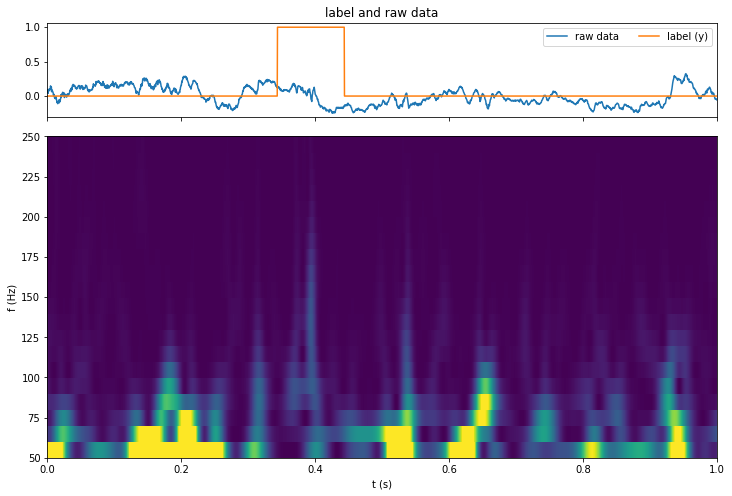

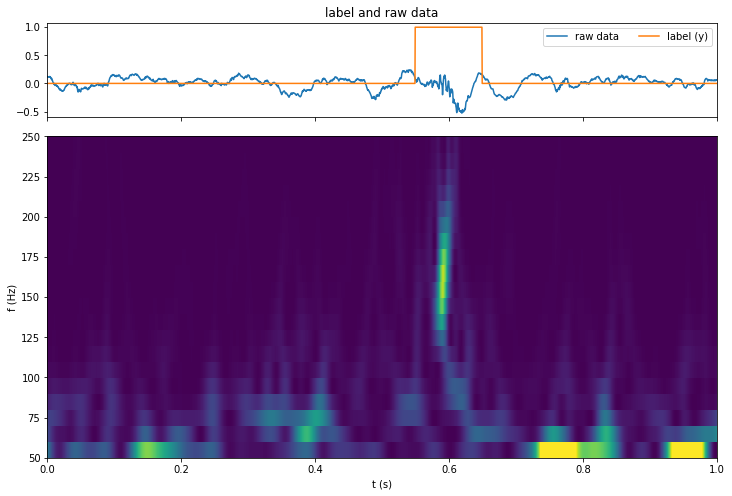

In [9]:
# plot wavelet spectrograms vs. labels and raw data for some samples
for i in range(3):
    gs = GridSpec(4, 1)
    fig = plt.figure(figsize=(12, 8))
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(time, X0[i, ], label='raw data')
    ax0.plot(time, Y[i, :, 0], label='label (y)' )
    ax0.legend(ncol=2)
    ax0.axis(ax0.axis('tight'))
    ax0.set_title('label and raw data')
    plt.setp(ax0.get_xticklabels(), visible=False)
    
    ax1 = fig.add_subplot(gs[1:, 0], sharex=ax0)
    im = ax1.pcolormesh(time, waveletfreqs, X[i, ].T, vmin=0, vmax=X.std()*2)
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylabel('f (Hz)')
    ax1.set_xlabel('t (s)')

# Set up recurrent neural network

In [10]:
def generate_model(input_shape, lr=0.01, dropout_rate=0.2, layer_sizes=[5, 5, 5], ):
    keras.backend.clear_session()

    # input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # conv layer
    x = keras.layers.Conv1D(layer_sizes[0], 
                            kernel_size=5, strides=1, 
                            padding='same'
                           )(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    
    # LSTM layer 1
    x = keras.layers.LSTM(layer_sizes[1], return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)  
    x = keras.layers.Dropout(dropout_rate)(x)
    
    # LSTM layer 2
    x = keras.layers.LSTM(layer_sizes[2], return_sequences=True)(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
        
    # dense output layer
    predictions = keras.layers.TimeDistributed(
        keras.layers.Dense(1, activation='sigmoid'))(x)
    
    # Define model
    model = keras.models.Model(inputs=inputs, outputs=predictions)

    opt = keras.optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])

    return model

In [11]:
model = generate_model(input_shape=(None, X.shape[2]))

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 21)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 5)           530       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 5)           20        
_________________________________________________________________
activation (Activation)      (None, None, 5)           0         
_________________________________________________________________
dropout (Dropout)            (None, None, 5)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 5)           220       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 5)           20    

In [13]:
history = model.fit(X[:-n_val_samples, :, :], Y[:-n_val_samples, :, :], 
                    batch_size=20, epochs=20, 
                    validation_data=(X[-n_val_samples:, :, :], Y[-n_val_samples:, :, :]))

Train on 537 samples, validate on 50 samples
Epoch 1/20
537/537 [==============================] - 23s 43ms/sample - loss: 0.5840 - accuracy: 0.7198 - mse: 0.1946 - val_loss: 0.4091 - val_accuracy: 0.8797 - val_mse: 0.1182
Epoch 2/20
537/537 [==============================] - 13s 24ms/sample - loss: 0.3556 - accuracy: 0.8969 - mse: 0.0993 - val_loss: 0.3470 - val_accuracy: 0.8797 - val_mse: 0.1004
Epoch 3/20
537/537 [==============================] - 13s 23ms/sample - loss: 0.2907 - accuracy: 0.9037 - mse: 0.0804 - val_loss: 0.3473 - val_accuracy: 0.8797 - val_mse: 0.1015
Epoch 4/20
537/537 [==============================] - 13s 24ms/sample - loss: 0.2723 - accuracy: 0.9013 - mse: 0.0768 - val_loss: 0.3299 - val_accuracy: 0.8797 - val_mse: 0.0971
Epoch 5/20
537/537 [==============================] - 13s 23ms/sample - loss: 0.2650 - accuracy: 0.9043 - mse: 0.0745 - val_loss: 0.3289 - val_accuracy: 0.8797 - val_mse: 0.0970
Epoch 6/20
537/537 [==============================] - 13s 23ms/sa

Text(0.5, 1.0, 'training/validation loss')

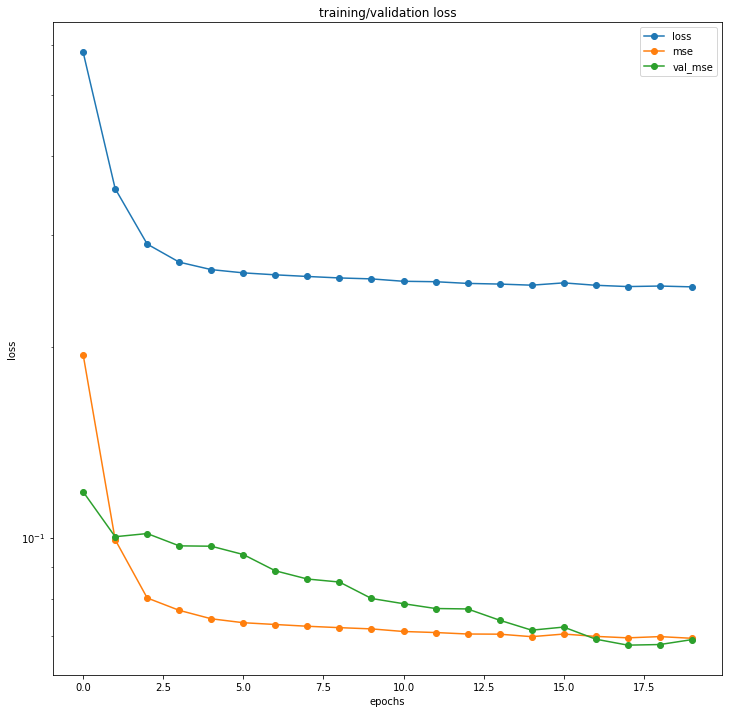

In [20]:
plt.figure(figsize=(12, 12))
plt.semilogy(history.history['loss'], '-o', label='loss')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training/validation loss')

Text(0.5, 0, '$t$ (s)')

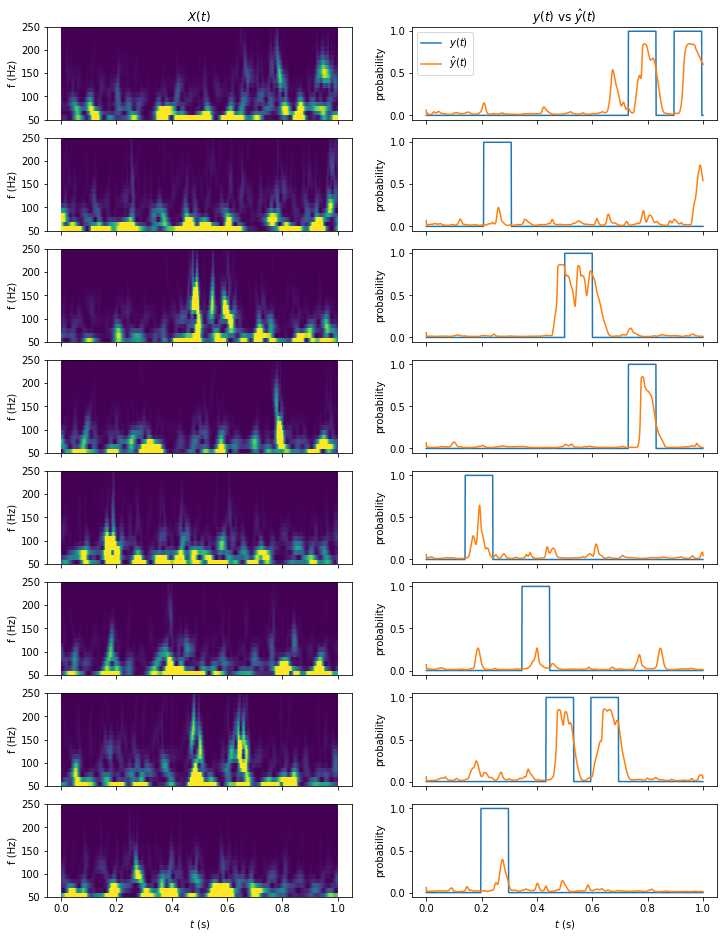

In [21]:
# visualize predictions on some samples from the validation set
#n_val_samples = 3
n_plots = 8
X_val = X[-n_val_samples:, ]
Y_val = Y[-n_val_samples:, ]

Y_pred = model.predict(X_val)

# compare prediction to ground truth
fig, axes = plt.subplots(n_plots, 2, figsize=(12, 16), 
                         sharex=True, sharey='col')
for i in range(n_plots):
    axes[i, 0].pcolormesh(time, waveletfreqs, X_val[i].T, vmin=0, vmax=X.std()*2)
    axes[i, 1].plot(time, Y_val[i], label='$y(t)$')
    axes[i, 1].plot(time, Y_pred[i], label='$\hat{y}(t)$')
    if i == 0:
        axes[i, 1].legend()
        axes[i, 0].set_title('$X(t)$')
        axes[i, 1].set_title('$y(t)$ vs $\hat{y}(t)$')
    axes[i, 0].set_ylabel('f (Hz)')
    axes[i, 1].set_ylabel('probability')
axes[i, 0].set_xlabel('$t$ (s)')
axes[i, 1].set_xlabel('$t$ (s)')

In [ ]:
# TODO: compute and show confusion matrix based on threshold crossings in predicted labels